Сгенерируем выборку

In [9]:
import numpy as np
import scipy.stats as sps
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate

%matplotlib inline
mpl.rcParams['figure.figsize'] = (14, 8)

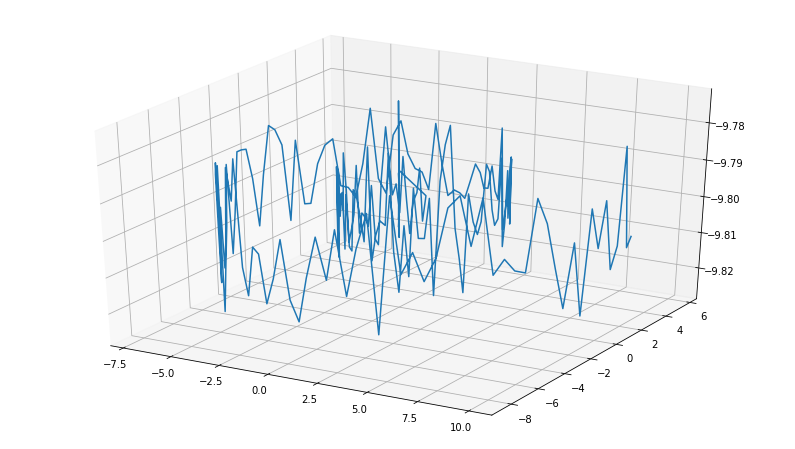

In [62]:
def gen_data(frequency, dispersion, calib_time, duration, gravity=9.8):
    t = np.arange(1, duration + calib_time + 1, 1 / frequency) * 1000
    t += sps.truncnorm.rvs(-2, 2, scale=1, size=t.shape)
    t = np.round(t)
    calib_pref = np.round(calib_time * frequency)
    true_pos = np.zeros((len(t), 3))
    t_raw = t / 1000
    t_shifted = t_raw[calib_pref:] - calib_time - 1
    true_pos[calib_pref:, 0] = t_shifted * np.cos(t_shifted)
    true_pos[calib_pref:, 1] = t_shifted * np.sin(t_shifted)
    true_pos[calib_pref:, 2] = np.zeros_like(t_shifted)
    true_a = np.zeros((len(t), 3))
    true_a[calib_pref:, 0] = -2 * np.sin(t_shifted) - t_shifted * np.cos(t_shifted)
    true_a[calib_pref:, 1] = 2 * np.cos(t_shifted) - t_shifted * np.sin(t_shifted)
    true_a[calib_pref:, 2] = np.zeros_like(t_shifted)
    res_a = true_a
    # add gravity
    res_a[:, 2] -= gravity
    res_a += sps.norm.rvs(scale=dispersion, size=res_a.shape)
    
    X = np.concatenate((t[:, None], res_a), axis=1)
    return X, true_pos
    
X, y = gen_data(20, 0.01, 1, 10)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(X[:, 1], X[:, 2], X[:, 3])

In [63]:
def error(y, y_pred):
    return ((y - y_pred) ** 2).mean()

Базовый алгоритм

100
12.42450570274646


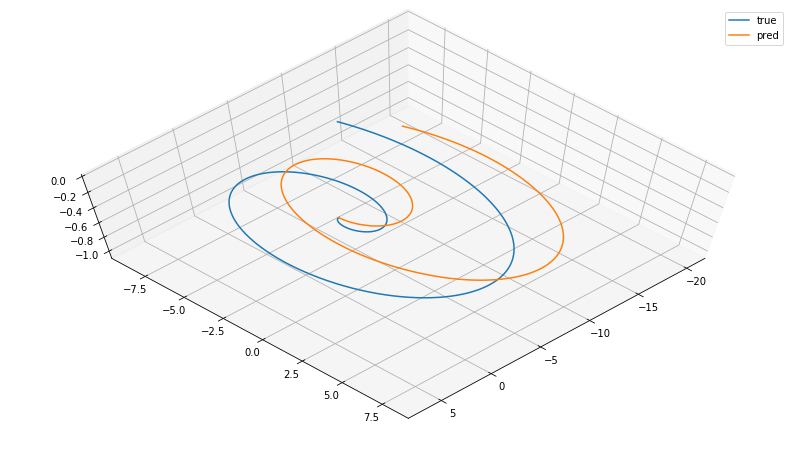

In [64]:
def naive_integrate(X, calib_time):
    calib_time *= 1000 / 2
    t0 = X[0, 0]
    calib_pref = np.argmin(np.abs(X[:, 0] - t0 - calib_time))
    grav = X[:calib_pref].mean(axis=0)
    grav[0] = 0
    print(calib_pref)
    X_cor = X - grav[None, :]
    t = X[:, 0] / 1000
    v = integrate.cumtrapz(X_cor[:, 1:], t, axis=0, initial=0)
    pos = integrate.cumtrapz(v, t, axis=0, initial=0)
    return pos

X, y = gen_data(200, 0.2, 1, 10)
y_pred = naive_integrate(X, 1)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(y[:, 0], y[:, 1], y[:, 2], label='true')
ax.plot(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], label='pred')
ax.legend()
ax.view_init(70, 45)
print(error(y, y_pred))